In [1]:
import numpy as np
  
from keras.models import Model, Sequential
from keras.layers import Input, Conv2D, UpSampling2D, Conv2DTranspose, GlobalAveragePooling2D
from keras.layers import concatenate, LeakyReLU, BatchNormalization, Dense, Activation, Reshape
from keras.optimizers import *
from keras.datasets import mnist

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

(X_train, _), (_, _) = mnist.load_data()
X_train = np.reshape(X_train, (-1, 28, 28, 1))/255

Using TensorFlow backend.


In [2]:
from typing import List
from unet import unet_cell # Local import

In [3]:
# Note: Support for type hints only in Python >= 3.5
def build_upscaler(inputs: Input,
                   num_filters_in_layer: List[int]=[16, 32, 64],
                   num_cells_in_layer: List[int]=[3, 3, 3],
                   bottleneck_before_concat: bool=False) -> Model:
    """Build a model which upscales inputs by factor of 4 (i.e., 
       doubles the height and width of inputs)
    
    # Arguments
    
    # Returns
    """
    # Validate inputs
    if len(num_filters_in_layer) != len(num_cells_in_layer):
        raise ValueError("len(num_filters_in_layer) should equal "
            "len(num_cells_in_layer). Received lengths: "
            "({}, {})".format(len(num_filters_in_layer), len(num_cells_in_layer)))
    
    x = inputs
    x = UpSampling2D()(x)
    carry_forward_tensors = []

    # Zip the parameters that apply to the contraction-side (exclude last 
    # parameter for bottom layer)
    contraction_filters_and_cells = zip(num_filters_in_layer[:-1],
                                        num_cells_in_layer[:-1])

    # Contraction
    for i, (num_filters, num_cells) in enumerate(contraction_filters_and_cells):
        if i == 0:
            # First layer does not downsample
            for j in range(num_cells):
                x = unet_cell(x, num_filters=num_filters) 
                # Note: We make extensive use of default values.
        else:
            # Downsample first
            x = unet_cell(x, num_filters=num_filters, strides=2)
            for j in range(num_cells - 1):
                x = unet_cell(x, num_filters=num_filters)
        carry_forward_tensors.append(x)

    # Bottom layer
    num_filters_at_bottom = num_filters_in_layer[-1]
    num_cells_at_bottom = num_cells_in_layer[-1]

    x = unet_cell(x, num_filters=num_filters_at_bottom, strides=2)
    for i in range(num_cells_at_bottom - 1):
        x = unet_cell(x, num_filters=num_filters_at_bottom)

    # Expansion
    filters_cells_and_carrys = reversed(list(zip(num_filters_in_layer[:-1],
                                                 num_cells_in_layer[:-1],
                                                 carry_forward_tensors)))
    for num_filters, num_cells, carry in filters_cells_and_carrys:
        x = unet_cell(x, transpose_conv=True, num_filters=num_filters, strides=2)
        if bottleneck_before_concat:
            x = unet_cell(x, num_filters=num_filters//2, kernel_size=1)
            carry = unet_cell(carry, num_filters=num_filters//2, kernel_size=1)
        x = concatenate([x, carry])
        for _ in range(num_cells - 1):
            x = unet_cell(x, num_filters=num_filters)

    # Output
    x = unet_cell(x, num_filters=1, kernel_size=1, activation='sigmoid',
                  batch_normalization=False)

    model = Model(inputs=inputs, outputs=x)
    return model

In [4]:
# TODO: Test keras.applications (ResNet, Xception, etc.) as discriminators
def build_discriminator():
    # TODO: Do we need two inputs?
    input1 = Input(shape=(None, None, 1))
    input2 = Input(shape=(None, None, 1))
    

    # input1 is upsampled, then taken through two unet_cells
    model1 = UpSampling2D()(input1)
    model1 = Conv2D(16, (3, 3), strides=(1,1), padding='same')(model1)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)
    model1 = Conv2D(16, (3, 3), strides=(1,1), padding='same')(model1)
    model1 = LeakyReLU(alpha=0.2)(model1)
    model1 = BatchNormalization(momentum=0.8)(model1)

    # input2 is taken directly through two unet_cells
    model = Conv2D(16, (3, 3), strides=(1,1), padding='same')(input2)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(16, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    
    # The two resulting tensors are then concatenated.
    model = concatenate([model, model1], axis=3)
    
    model = Conv2D(32, (3, 3), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(64, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(64, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    
    model = Conv2D(128, (3, 3), strides=(2,2), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(256, (3, 3), strides=(1,1), padding='same')(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Conv2D(256, (3, 3), strides=(1,1), padding='same')(model)
    model = GlobalAveragePooling2D()(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Dense(1024)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = BatchNormalization(momentum=0.8)(model)
    model = Dense(512)(model)
    model = LeakyReLU(alpha=0.2)(model)
    model = Dense(1)(model)
    model = Activation('sigmoid')(model)

    return Model(inputs=[input1, input2], outputs=model)

In [5]:
def build_old_discriminator():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), strides=(1,1), padding='same', input_shape=(None, None, 1)))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(16, (3, 3), strides=(1,1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    model.add(Conv2D(32, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(64, (3, 3), strides=(1,1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(128, (3, 3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, (3, 3), strides=(1,1), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Conv2D(256, (3, 3), strides=(1,1), padding='same'))
    model.add(GlobalAveragePooling2D())
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    # model.add(Flatten())
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    # model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    model.summary()
    
    img = Input(shape=(None, None, 1))
    validity = model(img)

    return Model(img, validity)

In [6]:
x = Input(shape=(None, None, 1))
# Note: dimensions of x should probably be divisible by 2**{num_layers}

# generator = build_generator()
generator = build_upscaler(x) # Use default parameters

optimizer = Adam(0.001, 0.5)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

optimizer1 = Adam(0.0002, 0.5)
discriminator = build_old_discriminator()
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer1, metrics=['accuracy'])

discriminator.trainable = False

# The generator takes noise as input and generated imgs
img = generator(x) # Calling the model on y (the upscaled input)

valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# low-res image as input and returns an upsampled image from the generator and a 
# validity score given by the discriminator
combined = Model(x, [valid, img])
combined.compile(loss=['binary_crossentropy', 'mean_absolute_error'], optimizer=optimizer, metrics = ['accuracy'])

# Note that the combined model was compiled *after* freezing the discriminator's weights

combined.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, None, None, 16)    160       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, None, None, 16)    0         
_________________________________________________________________
batch_normalization_16 (Batc (None, None, None, 16)    64        
_________________________________________________________________
conv2d_16 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
leaky_re_lu_17 (LeakyReLU)   (None, None, None, 16)    0         
_________________________________________________________________
batch_normalization_17 (Batc (None, None, None, 16)    64        
_________________________________________________________________
conv2d_17 (Conv2D)           (None, None, None, 32)    4640      
__________

/opt/modules/devel/python/3.5.2/lib/python3.5/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss: 0.126742, acc.: 99.50%] [G loss: 3.685876]


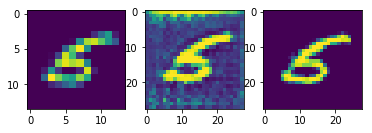

200 [D loss: 0.022210, acc.: 100.00%] [G loss: 5.012583]


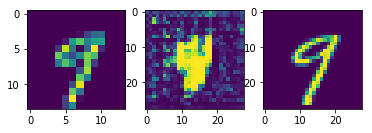

300 [D loss: 0.669693, acc.: 62.00%] [G loss: 3.828538]


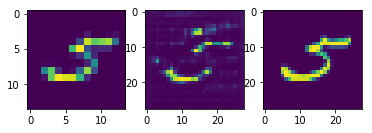

400 [D loss: 0.927719, acc.: 35.00%] [G loss: 1.339027]


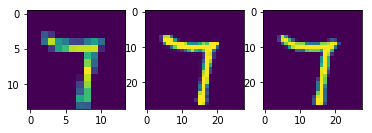

500 [D loss: 0.706765, acc.: 55.00%] [G loss: 0.968638]


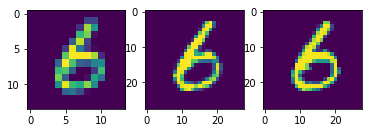

600 [D loss: 0.735277, acc.: 49.50%] [G loss: 0.967341]


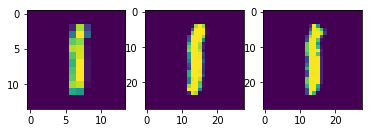

700 [D loss: 0.720192, acc.: 52.00%] [G loss: 0.970068]


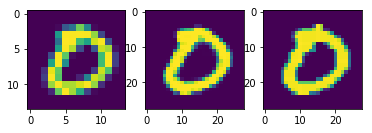

800 [D loss: 0.752596, acc.: 46.00%] [G loss: 0.813454]


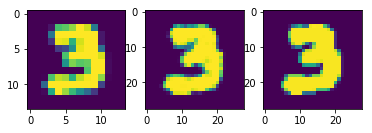

900 [D loss: 0.663673, acc.: 57.50%] [G loss: 0.942782]


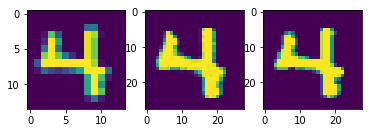

1000 [D loss: 0.690421, acc.: 56.00%] [G loss: 0.944929]


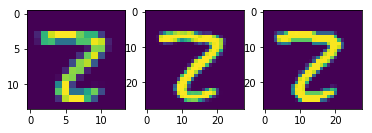

1100 [D loss: 0.833128, acc.: 28.50%] [G loss: 0.788679]


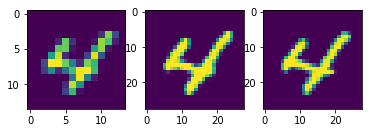

1200 [D loss: 0.692282, acc.: 55.00%] [G loss: 1.197846]


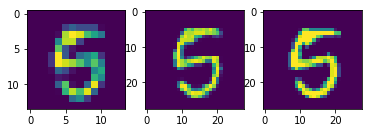

1300 [D loss: 0.676933, acc.: 54.50%] [G loss: 0.716044]


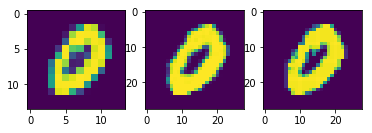

1400 [D loss: 0.476854, acc.: 86.00%] [G loss: 1.425807]


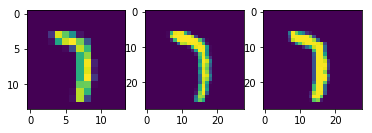

1500 [D loss: 0.115046, acc.: 100.00%] [G loss: 0.135479]


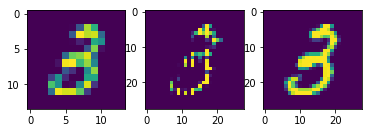

1600 [D loss: 0.995343, acc.: 32.00%] [G loss: 0.727747]


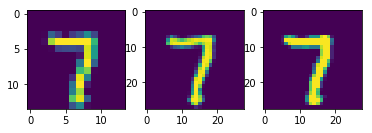

1700 [D loss: 0.288462, acc.: 91.00%] [G loss: 0.767473]


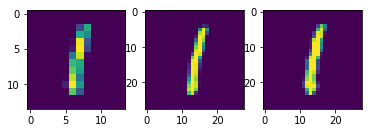

1800 [D loss: 0.939428, acc.: 50.00%] [G loss: 1.907342]


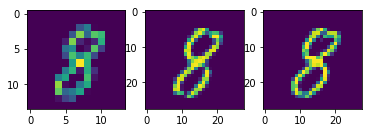

1900 [D loss: 0.258427, acc.: 97.50%] [G loss: 2.174605]


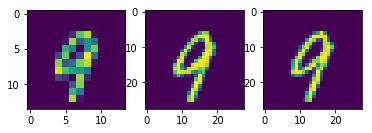

2000 [D loss: 0.168037, acc.: 98.50%] [G loss: 0.834426]


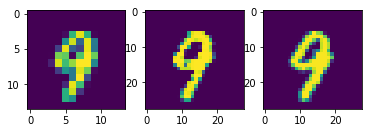

2100 [D loss: 0.494312, acc.: 81.00%] [G loss: 0.920815]


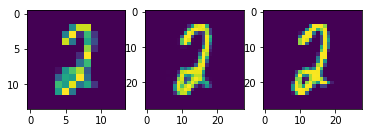

2200 [D loss: 0.313904, acc.: 93.00%] [G loss: 1.951891]


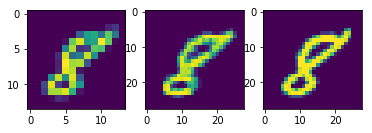

2300 [D loss: 1.046766, acc.: 17.00%] [G loss: 0.937463]


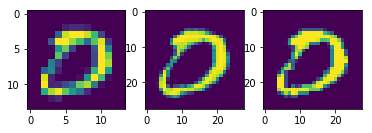

2400 [D loss: 0.246437, acc.: 98.00%] [G loss: 0.212822]


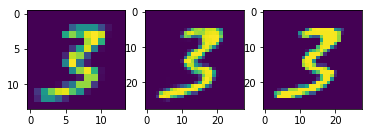

2500 [D loss: 0.178852, acc.: 98.50%] [G loss: 0.392071]


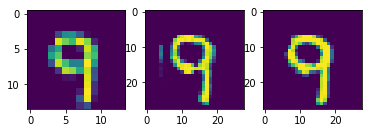

2600 [D loss: 0.636161, acc.: 65.50%] [G loss: 1.942888]


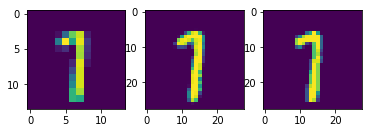

2700 [D loss: 1.244245, acc.: 12.00%] [G loss: 1.159530]


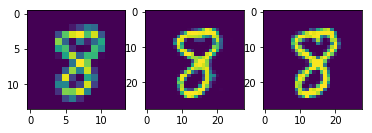

2800 [D loss: 0.946968, acc.: 41.00%] [G loss: 2.076250]


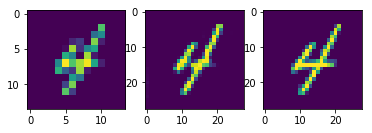

2900 [D loss: 0.267238, acc.: 97.50%] [G loss: 1.088620]


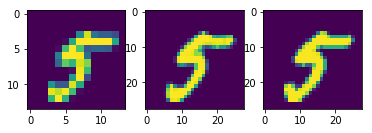

3000 [D loss: 0.731442, acc.: 48.50%] [G loss: 1.157413]


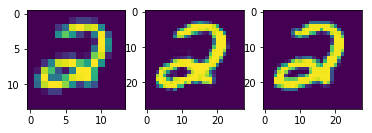

3100 [D loss: 0.441198, acc.: 84.50%] [G loss: 1.232154]


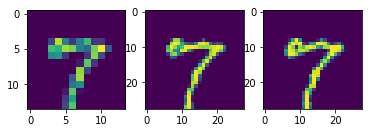

3200 [D loss: 0.548733, acc.: 73.00%] [G loss: 1.251474]


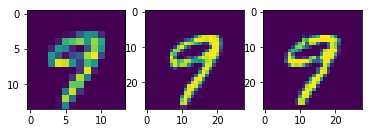

3300 [D loss: 0.714462, acc.: 53.00%] [G loss: 1.048817]


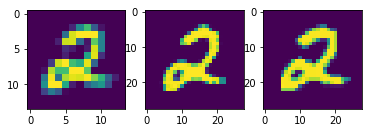

3400 [D loss: 0.351385, acc.: 96.00%] [G loss: 1.351628]


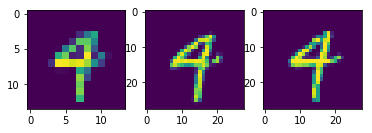

3500 [D loss: 0.453512, acc.: 90.00%] [G loss: 1.561302]


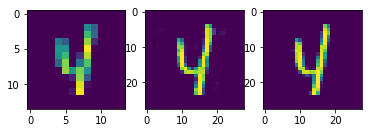

3600 [D loss: 0.602720, acc.: 67.00%] [G loss: 1.558721]


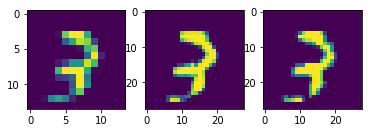

3700 [D loss: 0.558272, acc.: 71.00%] [G loss: 1.811924]


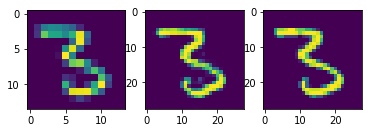

3800 [D loss: 0.309372, acc.: 93.50%] [G loss: 2.066574]


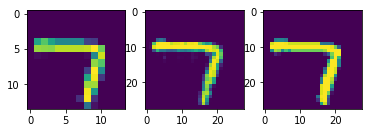

3900 [D loss: 0.946972, acc.: 38.50%] [G loss: 1.740055]


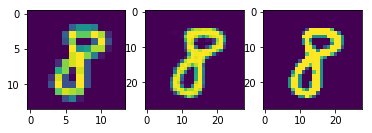

4000 [D loss: 1.030798, acc.: 23.00%] [G loss: 1.514084]


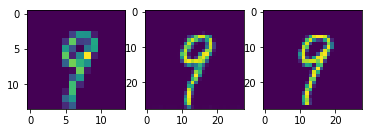

4100 [D loss: 0.497321, acc.: 80.50%] [G loss: 1.601162]


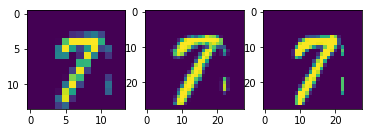

4200 [D loss: 1.259395, acc.: 13.00%] [G loss: 1.231695]


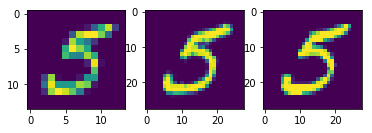

4300 [D loss: 0.438356, acc.: 88.50%] [G loss: 1.507111]


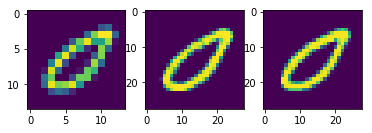

4400 [D loss: 0.694856, acc.: 59.50%] [G loss: 1.204378]


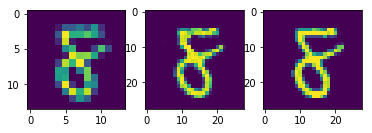

4500 [D loss: 0.633022, acc.: 65.00%] [G loss: 0.652375]


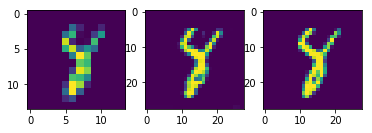

4600 [D loss: 0.444610, acc.: 84.00%] [G loss: 2.139297]


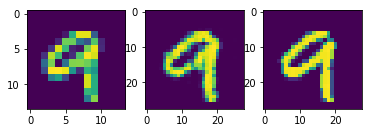

4700 [D loss: 0.531411, acc.: 73.00%] [G loss: 2.009790]


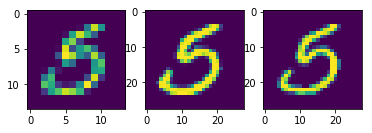

4800 [D loss: 0.948313, acc.: 24.00%] [G loss: 0.779030]


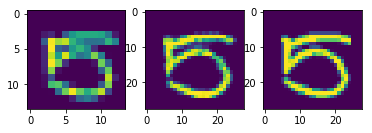

4900 [D loss: 0.970358, acc.: 31.50%] [G loss: 0.900123]


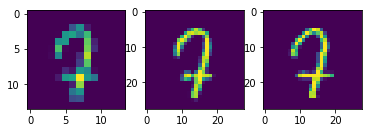

5000 [D loss: 0.513796, acc.: 66.50%] [G loss: 1.177962]


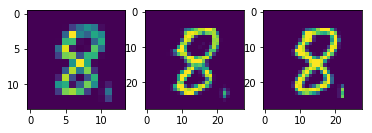

5100 [D loss: 0.813214, acc.: 39.50%] [G loss: 1.080022]


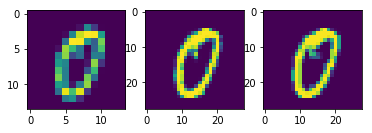

5200 [D loss: 0.831060, acc.: 53.00%] [G loss: 1.475664]


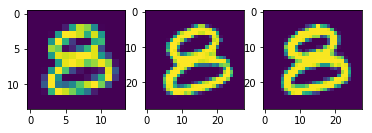

5300 [D loss: 0.333336, acc.: 95.00%] [G loss: 1.575848]


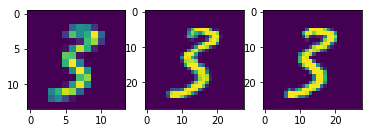

5400 [D loss: 0.796051, acc.: 48.00%] [G loss: 0.768724]


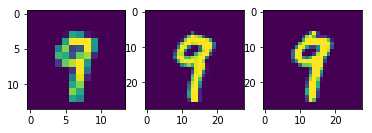

5500 [D loss: 0.949318, acc.: 29.00%] [G loss: 0.824912]


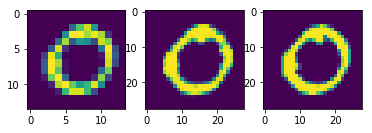

5600 [D loss: 0.816458, acc.: 37.00%] [G loss: 1.908982]


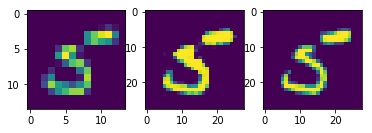

5700 [D loss: 0.776251, acc.: 42.50%] [G loss: 0.980612]


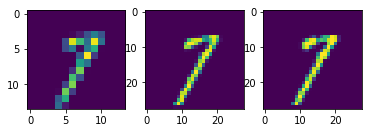

5800 [D loss: 0.546778, acc.: 76.00%] [G loss: 0.803563]


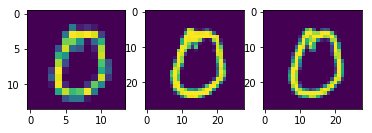

5900 [D loss: 0.604948, acc.: 70.50%] [G loss: 1.431392]


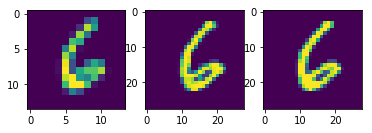

6000 [D loss: 0.400489, acc.: 89.50%] [G loss: 1.052575]


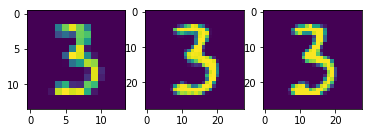

6100 [D loss: 0.296019, acc.: 96.00%] [G loss: 2.025365]


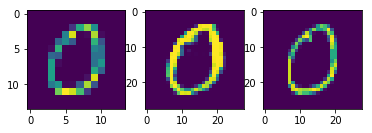

6200 [D loss: 1.113820, acc.: 10.00%] [G loss: 0.949303]


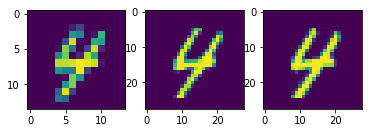

6300 [D loss: 0.528674, acc.: 78.00%] [G loss: 1.246907]


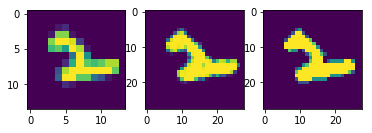

6400 [D loss: 0.885098, acc.: 51.00%] [G loss: 0.802878]


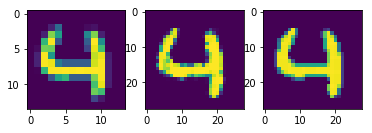

6500 [D loss: 0.213105, acc.: 98.00%] [G loss: 1.598890]


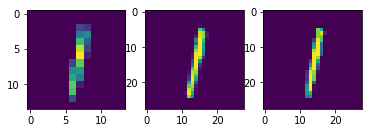

6600 [D loss: 0.209118, acc.: 100.00%] [G loss: 2.228545]


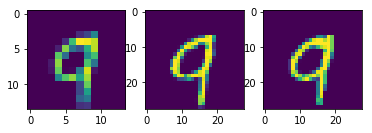

6700 [D loss: 0.201122, acc.: 100.00%] [G loss: 1.692387]


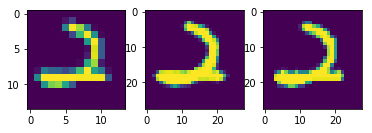

6800 [D loss: 0.571916, acc.: 70.50%] [G loss: 2.044295]


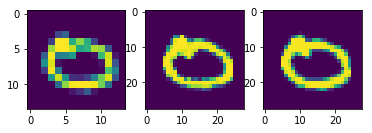

6900 [D loss: 0.442813, acc.: 72.00%] [G loss: 0.746067]


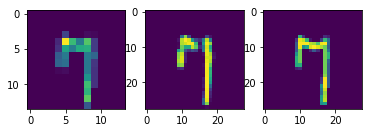

7000 [D loss: 0.686145, acc.: 56.50%] [G loss: 1.130527]


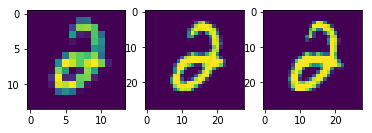

7100 [D loss: 0.287120, acc.: 96.50%] [G loss: 1.521976]


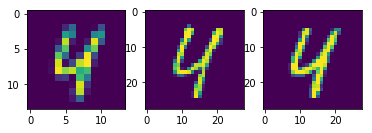

7200 [D loss: 0.414952, acc.: 82.00%] [G loss: 0.987786]


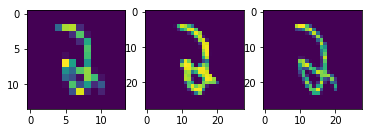

7300 [D loss: 0.714423, acc.: 52.00%] [G loss: 1.236928]


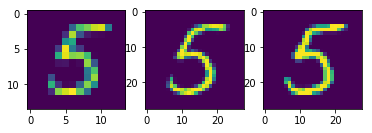

7400 [D loss: 1.156817, acc.: 23.50%] [G loss: 2.033319]


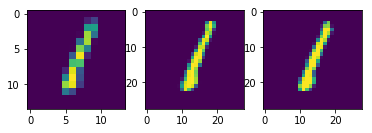

7500 [D loss: 0.336652, acc.: 90.00%] [G loss: 0.986629]


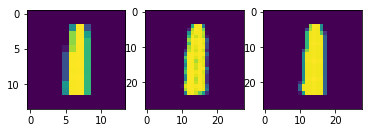

7600 [D loss: 0.521613, acc.: 69.00%] [G loss: 1.839894]


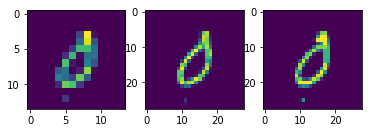

7700 [D loss: 0.994409, acc.: 50.00%] [G loss: 1.495165]


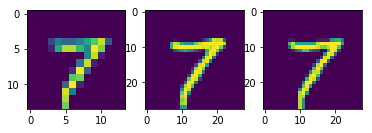

7800 [D loss: 0.856224, acc.: 52.00%] [G loss: 1.180396]


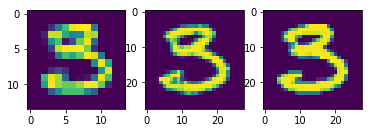

7900 [D loss: 0.086986, acc.: 100.00%] [G loss: 2.897890]


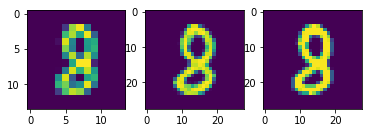

8000 [D loss: 0.325719, acc.: 95.00%] [G loss: 0.973852]


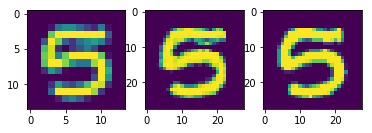

8100 [D loss: 0.190024, acc.: 97.00%] [G loss: 2.185551]


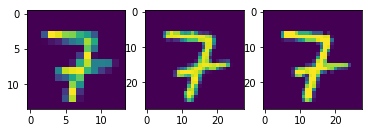

8200 [D loss: 0.556020, acc.: 65.00%] [G loss: 0.921709]


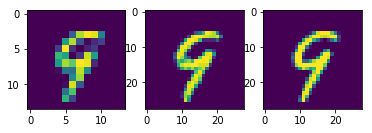

8300 [D loss: 0.203431, acc.: 99.00%] [G loss: 1.903576]


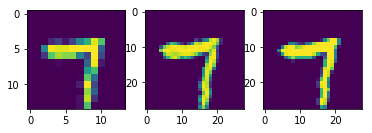

8400 [D loss: 0.337592, acc.: 89.50%] [G loss: 1.962291]


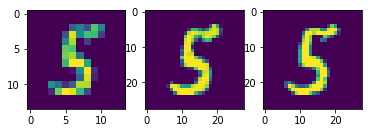

8500 [D loss: 0.329572, acc.: 91.00%] [G loss: 1.387204]


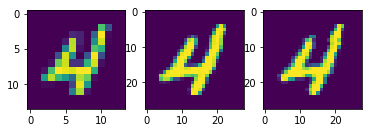

8600 [D loss: 0.262839, acc.: 91.00%] [G loss: 0.291210]


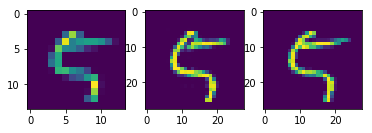

8700 [D loss: 0.087004, acc.: 100.00%] [G loss: 2.090489]


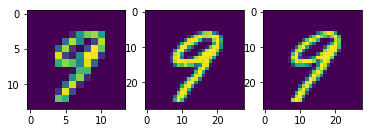

8800 [D loss: 0.480608, acc.: 80.00%] [G loss: 2.601885]


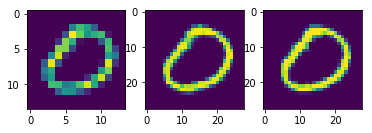

8900 [D loss: 0.353351, acc.: 83.50%] [G loss: 2.455676]


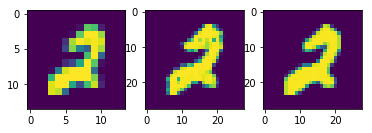

9000 [D loss: 0.189015, acc.: 99.50%] [G loss: 3.377105]


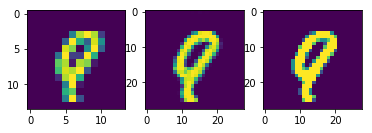

9100 [D loss: 0.369698, acc.: 84.50%] [G loss: 1.155858]


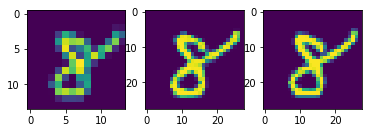

9200 [D loss: 0.293374, acc.: 94.00%] [G loss: 1.868330]


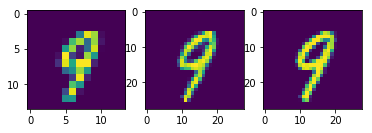

9300 [D loss: 0.571709, acc.: 71.00%] [G loss: 2.617997]


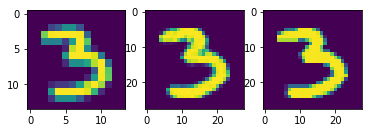

9400 [D loss: 0.112087, acc.: 99.50%] [G loss: 2.344451]


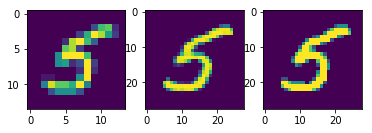

9500 [D loss: 1.078953, acc.: 51.50%] [G loss: 0.227802]


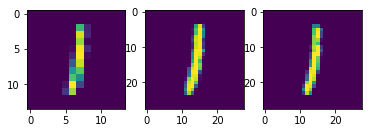

9600 [D loss: 0.362232, acc.: 85.50%] [G loss: 1.612182]


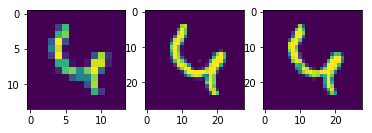

9700 [D loss: 0.210540, acc.: 97.50%] [G loss: 1.118619]


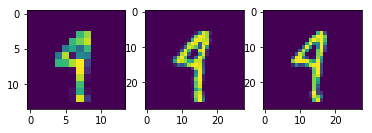

9800 [D loss: 0.117424, acc.: 99.50%] [G loss: 2.767087]


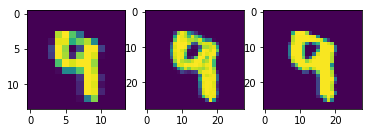

9900 [D loss: 0.336468, acc.: 91.50%] [G loss: 1.215732]


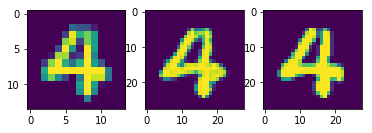

10000 [D loss: 0.523805, acc.: 70.00%] [G loss: 1.891453]


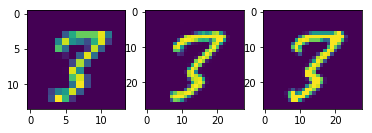

In [7]:
epochs = 10000
batch_size = 200
half_batch = int(batch_size/2)
def reduce_resolution(ims):
    O, M, N, P = ims.shape
    K = 2
    L = 2

    MK = M // K
    NL = N // L
    return ims.reshape(-1, MK, K, NL, L).mean(axis=(2, 4)).reshape(O, MK, NL, P)

# Unused function...?
def upsize(ims):
    return ims.repeat(2, axis = 1).repeat(2, axis = 2)

for epoch in range(1, epochs + 1):

    # ---------------------
    #  Train Discriminator
    # ---------------------

    # Select a random half batch of images
    idx = np.random.randint(0, X_train.shape[0], half_batch)
    imgs = X_train[idx]

    idx1 = np.random.randint(0, X_train.shape[0], half_batch)
    imgs1 = X_train[idx1]
    noise1 = reduce_resolution(imgs1)

    # Generate a half batch of new images
    gen_imgs = generator.predict(noise1)
    # gen_imgs are now upsampled to original resolution
    
    # Train the discriminator
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  Train Generator
    # ---------------------

    idx2 = np.random.randint(0, X_train.shape[0], batch_size)
    noise2 = reduce_resolution(X_train[idx2])

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
    valid_y = np.array([1] * batch_size)
    
    # Train the generator
    g_loss = combined.train_on_batch(noise2, [valid_y, X_train[idx2]])
        
    if epoch % 100 == 0:
        # Plot the progress
        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0]))
        fig, ax = plt.subplots(1, 3)
        ax[0].imshow(np.reshape(noise1[0], (14, 14)))
        ax[1].imshow(np.reshape(gen_imgs[0], (28, 28)))
        ax[2].imshow(np.reshape(imgs1[0], (28, 28)))
        plt.show()


In [8]:
generator.save('./models/generator_mnist.h5')
discriminator.save('./models/discriminator_mnist.h5')
combined.save('./models/combined_mnist.h5')